In [11]:
from pyspecter.SPECTER import SPECTER
from pyshaper.Shaper import Shaper

# Utils
from pyspecter.utils.data_utils import load_cmsopendata, load_triangles, random_triangles, kT_N
from pyspecter.utils.plot_utils import initialize, newplot, plot_event
initialize()


# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import time

# Necessary GPU nonsense for SHAPER
import torch 
if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


In [12]:
# CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset = "CMS"
n_samples = # CMS Open Sim Parameters
R = 0.5
pt_lower = 475
pt_upper = 525
eta_cut = 1.9
quality = 2
pad = 100 # Note that runtime is pad^2, memory is pad^4

dataset = "CMS"
n_samples = 2500*2
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

if dataset == "CMS":

    # Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
    dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = 1000000, amount=1)
    weights = sim_weights * k_factors

    print("Loaded dataset with {} events".format(len(dataset)))
    print("Trimmig to {} events".format(n_samples)  )
    shuffle = np.random.permutation(len(dataset),)[:n_samples]
    dataset = dataset[shuffle]
    weights = weights[shuffle]

    dataset = kT_N(dataset, 2, R)



elif dataset == "Random Points":

    dataset, weights = random_triangles(n_samples, R)

# Split dataset into 2 halves
dataset1 = dataset[:n_samples//2]
dataset2 = dataset[n_samples//2:]
weights1 = weights[:n_samples//2]
weights2 = weights[n_samples//2:]
2500*2
batch_size = 1 # Number of pairs to process in parallel, can probably be increased.

if dataset == "CMS":

    # Load data -- this will take a while the first time. Downloads the data from the CMS Open Data portal. Sub in your own data if you have if you want.
    dataset, sim_weights, k_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta_cut, quality, pad = pad, n = 1000000, amount=1)
    weights = sim_weights * k_factors

    print("Loaded dataset with {} events".format(len(dataset)))
    print("Trimmig to {} events".format(n_samples)  )
    shuffle = np.random.permutation(len(dataset),)[:n_samples]
    dataset = dataset[shuffle]
    weights = weights[shuffle]

    dataset = kT_N(dataset, 2, R)



elif dataset == "Random Points":

    dataset, weights = random_triangles(n_samples, R)

# Split dataset into 2 halves
dataset1 = dataset[:n_samples//2]
dataset2 = dataset[n_samples//2:]
weights1 = weights[:n_samples//2]
weights2 = weights[n_samples//2:]


Max # of particles: 146
Loaded dataset with 46166 events
Trimmig to 5000 events


[[ 0.789088   -0.07148052 -0.00513306]
 [ 0.210912    0.26742818  0.01876606]]


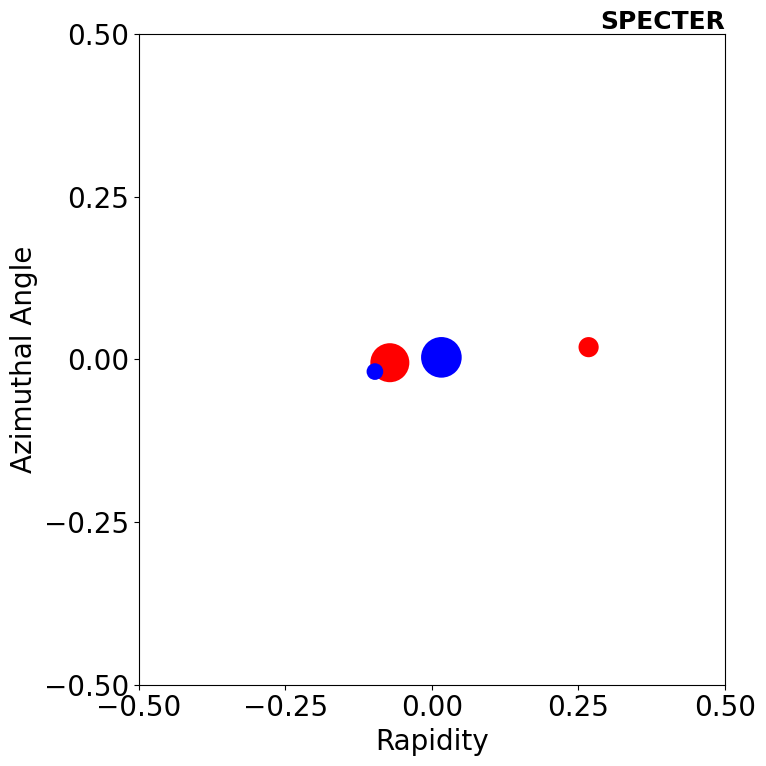

In [13]:
# Plots
fig, ax = newplot()

# Plot the first event
plot_event(ax, dataset1[0],R, color = "red")
print(dataset1[0])
plot_event(ax, dataset2[0],R, color = "blue")


In [16]:
# Set up and compile SPECTER
specter = SPECTER(compile = True)

start = time.time()
specter_emds = specter.spectralEMD(dataset1, dataset2)
end = time.time()
print("SPECTER took {} seconds".format(end - start))

# Set up and compile SHAPER
shaper = Shaper({}, device)
shaper.to(device)

start = time.time()
shaper_emds = shaper.pairwise_emds_isometry(dataset1, dataset2, R = R, beta = 2, lr = 0.01, epsilon = 0.001)
shaper_emds_no_isometry = shaper.pairwise_emds2(dataset1, dataset2, R = R, beta = 2, epsilon = 0.01)
end = time.time()
print("SHAPER took {} seconds".format(end - start))


Compiling SPECTER model...
Generating test events for tracing ...
Test events generated! Time taken:  1.5359392166137695  seconds.
Compiling spectral representation functions ...
Compiling observables...
Observables compiled! Time taken:  22.111390352249146  seconds.
Compilation complete! Time taken:  22.111398220062256  seconds.
SPECTER took 0.36498284339904785 seconds
Epoch 0 Mean Loss = 0.018251897745673342 Elapsed time = 0.060s Percentage done = 0.000 
Epoch 1 Mean Loss = 0.018650269738875794 Elapsed time = 0.107s Percentage done = 0.000 
Epoch 2 Mean Loss = 0.01860676829731965 Elapsed time = 0.163s Percentage done = 0.000 
Epoch 3 Mean Loss = 0.018759084844705648 Elapsed time = 0.226s Percentage done = 0.000 
Epoch 4 Mean Loss = 0.01893958292271127 Elapsed time = 0.282s Percentage done = 0.000 
Epoch 5 Mean Loss = 0.01899086280593183 Elapsed time = 0.339s Percentage done = 0.000 
Epoch 6 Mean Loss = 0.01899329901110614 Elapsed time = 0.397s Percentage done = 0.000 
Epoch 7 Mean Lo

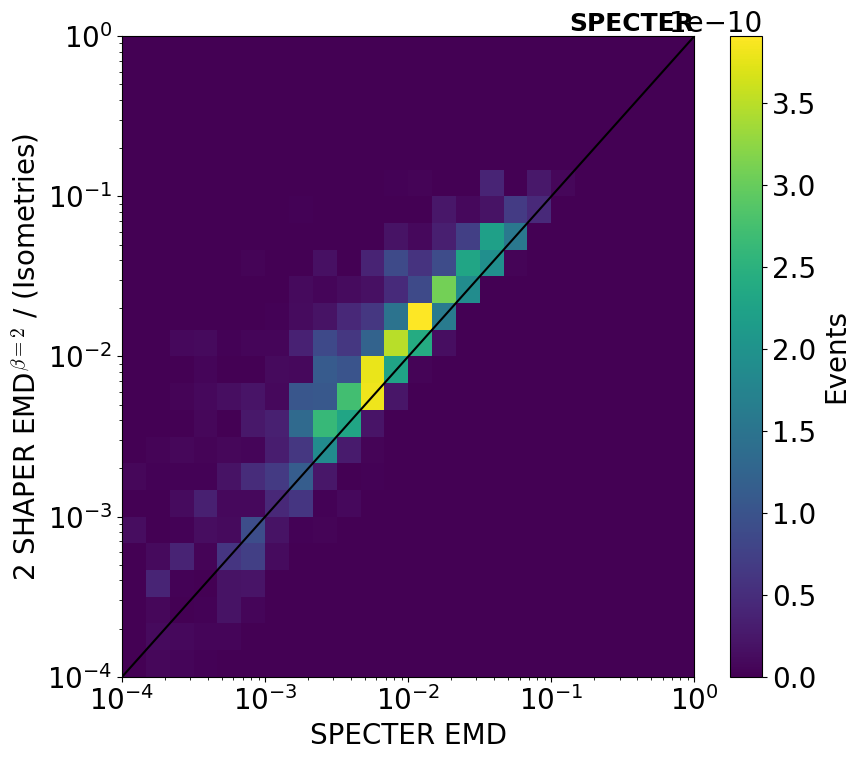

In [17]:
import matplotlib

# plt.scatter(specter_emds, shaper_emds)
# plt.scatter(specter_emds, shaper_emds_no_isometry)

# log 2d histogram
newplot(width=9)

log = False
xbins = np.logspace(-4, 0, 25)
ybins = np.logspace(-4, 0, 25)
if log:
    plt.hist2d(specter_emds, shaper_emds, norm = matplotlib.colors.LogNorm(), bins = [xbins, ybins], density=False, weights=weights1*weights2)
else:
    plt.hist2d(specter_emds, shaper_emds, bins = [xbins, ybins], density=False, weights=weights1*weights2)
# diagonal line
x = np.linspace(0, 1, 1000)
plt.plot(x, x, color = "black")

plt.xlabel("SPECTER EMD")
plt.ylabel(r"2 SHAPER EMD$^{\beta = 2}$ / (Isometries)")
plt.xscale("log")
plt.yscale("log")
cbabr = plt.colorbar()
cbabr.set_label("Events")

